In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [2]:
import os
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../model')
sys.path.append('../../cost')
sys.path.append('../../constraints')
sys.path.append('../../utils')

In [3]:
import UnicycleModel
import UnicycleCost
import UnicycleConstraints
from scipy.integrate import solve_ivp
from matplotlib.patches import Ellipse
from utils_alg import get_neighbor_vec,get_K_discrete
from utils_plot import plot_traj,plot_traj_set,plot_state_input

In [4]:
from Single_PTR import Single_PTR

In [5]:
ix = 3
iu = 2
iw = 2
iq = 2
ip = 2
N = 30
tf = 3
delT = tf/N

In [6]:
# time-invariant matrices
C = np.array([[0,0,1],[0,0,0]])
D = np.array([[0,0],[1,0]])
E = np.array([[1,0],[0,1],[0,0]])


G = np.zeros((iq,iw))

## obstacle setting

In [7]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []
c1 = [1,2]
H1 = get_H_obs(0.75,1.5)
c_list.append(c1)
H_list.append(H1)
c2 = [4,3]
H2 = get_H_obs(0.75,1.5)
c_list.append(c2)
H_list.append(H2)

## initial and final conditions 

In [8]:
xi = np.zeros(3)
xi[0] = 0.0
xi[1] = 0.0 
xi[2] = 0

xf = np.zeros(3)
xf[0] = 5.0
xf[1] = 5.0
xf[2] = 0

xi_margin = np.array([0.1,0.1,np.deg2rad(5)])*2
Qf = np.diag([0.5**2,0.5**2,np.deg2rad(20)**2])*1.5
vec_neighbor = []
xi_neighbor = np.array(get_neighbor_vec(-1,0,ix,None,vec_neighbor)) * np.array(xi_margin) + xi

myModel = UnicycleModel.unicycle('Hello',ix,iu,iw,'numeric_central')
myCost = UnicycleCost.unicycle('Hello',ix,iu,N)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu)
myConst.set_obstacle(c_list,H_list)

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
u0 = np.zeros((N+1,iu))

A,B,s,z,x_prop_n = myModel.diff_discrete_zoh(x0[0:N,:],u0[0:N,:],delT,tf) 
S = np.eye(ix)
R = 2*np.eye(iu)
Kbar = get_K_discrete(A,B,S,R,S,N,ix,iu)
Qbar = np.tile(np.diag([0.35**2,0.35**2,np.deg2rad(10)**2]),(N+1,1,1))
Ybar = Kbar@Qbar[:N]
xbar,ubar = x0,u0

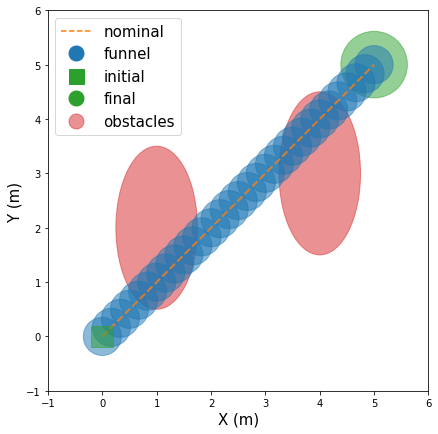

In [9]:
plt.figure(0,figsize=(7,7))
plot_traj_set(xbar,ubar,c_list,H_list,Qbar,xi=xi,xf=xf,xi_margin=xi_margin,Qf=Qf,plt=plt)

## step 1 : Nominal trajectory update (Single PTR)

In [10]:
# iteration = 0
i1 = Single_PTR('unicycle',N,tf,1,myModel,myCost,myConst,
          w_c=1,w_vc=1e3,w_tr=1e1,tol_vc=1e-6,tol_tr=1e-4,verbosity=True)


In [11]:
_,_,xnew,unew,total_num_iter,flag_boundary,l,l_vc,l_tr = i1.run(x0,u0,xi,xf,Qbar,Kbar)#,xi_neighbor,xf_margin)
# plot_traj(xbar,ubar,c_list,H_list,xf)
# plot_state_input(xbar,ubar,xi,xf,N,delT)

iteration   total_cost        cost        ||vc||     ||tr||       reduction   w_tr        bounary
1           5957.181          86.009      5           87.1        -4.96e+03   10.000      0( 5)


In [12]:
print_np(xnew)

Type is <class 'numpy.ndarray'>
Shape is (31, 3)


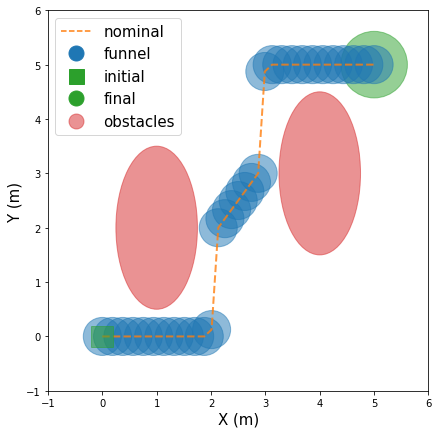

In [13]:
plt.figure(0,figsize=(7,7))
plot_traj_set(xnew,unew,c_list,H_list,Qbar,xi=xi,xf=xf,xi_margin=xi_margin,Qf=Qf,plt=plt)

## Discretization

In [14]:
A,B,F,s,z,x_prop_n = myModel.diff_discrete_zoh_noise(xnew,unew,np.zeros((N,iw)),delT,tf) 
sz = tf*s + z
# propagation
xprop,_ = i1.forward_multiple(xnew,unew)

In [15]:
print_np(xprop)

Type is <class 'numpy.ndarray'>
Shape is (30, 3)


## step 2 : Estimating $\gamma$

In [16]:
from utils_alg import get_sample_eta_w,propagate_model
import cvxpy as cvx
from scipy.integrate import solve_ivp

In [17]:
from EstimatingLipschitz import Lipschitz
myM = Lipschitz(ix,iu,iq,ip,iw,N)
myM.initialize(xnew,unew,xprop,Qbar,Kbar,A,B,C,D,E,F,G,myModel)

In [18]:
gamma = myM.update_lipschitz_parallel(myModel,delT)
print("mean of gamma",np.mean(gamma,0),"max of gamma",np.max(gamma,0),"var of gamma",np.var(gamma,0))

mean of gamma 0.015231192079210682 max of gamma 0.017506714292807674 var of gamma 6.57742107626561e-06


## step 3 : Funnel update

In [19]:
from LMI import Q_update

In [20]:
# propagation error
e_prop = np.linalg.norm(xprop - xnew[1:],axis=1)
print(e_prop)

[5.54916940e-10 5.44801117e-10 5.25512027e-10 4.97763408e-10
 4.62512593e-10 4.22784116e-10 3.83740571e-10 3.41682383e-10
 2.98095392e-10 2.40530951e-09 1.26071148e-01 1.87396319e+00
 1.66629865e-01 1.66669603e-01 1.66666184e-01 1.66666183e-01
 1.66669620e-01 1.66748416e-01 1.87384466e+00 1.26071116e-01
 9.36065857e-10 6.44583091e-10 6.88908261e-10 7.31488304e-10
 7.70903175e-10 8.10444888e-10 8.45666306e-10 8.73459912e-10
 8.92813245e-10 9.02957553e-10]


In [21]:
myQ = Q_update(ix,iu,iq,ip,iw,N,delT,myCost.S,myCost.R,w_tr=1,w_vc=1e3)

In [22]:
myQ.initialize(xnew,unew,e_prop*0,A,B,C,D,E,F,G)

In [25]:
alpha = 0.99
Q,K,Y,status = myQ.solve(alpha,gamma,xi_neighbor,Qf,Qbar,Ybar)
print("LMI status:" + status)

total_cost      cost         ||vc||     ||tr||
    20.372        15.6           0        4.77
LMI status:optimal


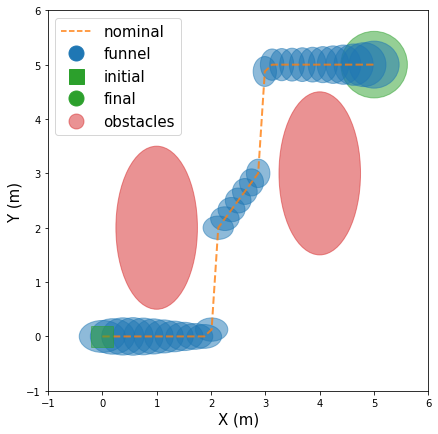

In [26]:
# plot the trajectory
plt.figure(0,figsize=(7,7))
plot_traj_set(xnew,unew,c_list,H_list,Q,xi=xi,xf=xf,xi_margin=xi_margin,Qf=Qf,plt=plt)
plt.show()

In [27]:
# obtain beta
beta = myQ.update_beta(Q,K,gamma,alpha)
print(beta)

# adjust Q
for i in range(N+1) :
    Q[i] = Q[i] * beta[i]

[1.         0.84202834 0.85518405 0.86977563 0.87245259 0.87042954
 0.87164673 0.87382009 0.87514564 0.87536838 0.87284671 0.86420315
 0.86008952 0.85767381 0.8553952  0.85325889 0.85125005 0.8493832
 0.84763657 0.84587838 0.84578156 0.84890653 0.84830148 0.84602262
 0.84316314 0.83967353 0.83553411 0.83226851 0.82969364 0.8270828
 0.82450024]


In [ ]:
# plot the trajectory
plt.figure(0,figsize=(7,7))
plot_traj_set(xnew,unew,c_list,H_list,Q,xi=xi,xf=xf,xi_margin=xi_margin,Qf=Qf,plt=plt)
plt.show()

In [28]:
max(3,2,4)

4